In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")

import tiktoken

# Count the number of tokens in each page_content
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string, disallowed_special=()))
    return num_tokens

splitter = RecursiveCharacterTextSplitter(
            chunk_size=50,
            chunk_overlap=0,
            length_function=num_tokens_from_string
        )


# Set the model to evaluation mode
model.eval()

with open('/home/paperspace/llama-repo/corpuses/wikitexts.md', 'r') as file:
    input_text = file.read()

# chunks = splitter.split_text(input_text)

# Define the input text
input_text = input_text[:4000]

# token_count = 0
# current_chunk = 0
# chunked_input = ''
# for i in range(current_chunk, len(chunks)):
#     token_count += num_tokens_from_string(chunks[i])
#     chunked_input += f"<|start_chunk_{i+1}|>{chunks[i]}<|end_chunk_{i+1}|>"
#     if token_count > 800:
#         break

# prompt = """
# <|begin_of_text|><|start_header_id|>system<|end_header_id|>

# You are an assistant specialized in splitting text into thematically consistent sections. The text has been divided into chunks, each marked with <|start_chunk_X|> and <|end_chunk_X|> tags, where X is the chunk number. Your task is to identify the points where splits should occur, such that consecutive chunks of similar themes stay together. Respond with a list of chunk IDs where you believe a split should be made. For example, if chunks 1 and 2 belong together but chunk 3 starts a new topic, you would suggest a split after chunk 2. Your response should be in the form: 'split_after: 3, 5'.<|eot_id|><|start_header_id|>user<|end_header_id|>

# CHUNKED_TEXT: CHUNKED_INPUT

# Respond only with the IDs of the chunks where you believe a split should occur.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

# split_after: 2, 4, 7, 9, 12<|eot_id|><|start_header_id|>assistant<|end_header_id|>
# """.replace("CHUNKED_INPUT", chunked_input)
# prompt = """
# <|begin_of_text|><|start_header_id|>system<|end_header_id|>

# You are an assistant specialized in splitting text into thematically consistent sections. The text has been divided into chunks, each marked with <|start_chunk_X|> and <|end_chunk_X|> tags, where X is the chunk number. Your task is to identify the points where splits should occur, such that consecutive chunks of similar themes stay together. Respond with a list of chunk IDs where you believe a split should be made. For example, if chunks 1 and 2 belong together but chunk 3 starts a new topic, you would suggest a split after chunk 2. Your response should be in the form: 'split_after: 3, 5'.<|eot_id|><|start_header_id|>user<|end_header_id|>

# CHUNKED_TEXT: CHUNKED_INPUT

# Respond only with the IDs of the chunks where you believe a split should occur.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

# split_after: 2, 4, 7
# """.replace("CHUNKED_INPUT", chunked_input)
prompt = """
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are an assistant specialized in splitting a corpus into thematically consistent sections. Read the following corpus and identify the points where splits should occur, such to create consecutive strips of similar themes. Respond with the text of each chunk. Here is an example response:

CORPUS: "The Ferari is a fast car. The Lamborghini is also a fast car. Toast can be made with bread. The toaster is used to make toast."

RESPONSE:
First Chunk: "The Ferari is a fast car. The Lamborghini is also a fast car."
Second Chunk: "Toast can be made with bread. The toaster is used to make toast."

Here is the corpus you will be working with:

<|begin_of_corpus|>CHUNKED_INPUT<|end_of_corpus|>

Respond with the chunk and it's corresponding text from the corpus above:<|eot_id|><|start_header_id|>assistant<|end_header_id|>

First Chunk: TEXT
Second Chunk: TEXT
Third Chunk: TEXT
Fourth Chunk: TEXT
""".replace("CHUNKED_INPUT", input_text)

# Tokenize the input text
input_ids = tokenizer.encode(prompt, return_tensors='pt')

print(len(input_ids[-1]))

# Get the model's outputs without tracking gradients
with torch.no_grad():
    outputs = model(input_ids, output_attentions=True)

# Print all the keys on outputs
# print(outputs.keys())

# print("Shape of logits:", outputs.logits.shape)


# # Print the shape of attentions
# print(len(outputs.attentions))
# print("Shape of attentions:", outputs.attentions[-1].shape)

# Unload the model from memory
del model
torch.cuda.empty_cache()


/home/paperspace/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 4/4 [00:16<00:00,  4.18s/it]
LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


1018


In [37]:
with open('/home/paperspace/llama-repo/corpuses/wikitexts.md', 'r') as file:
    input_text = file.read()

In [40]:
num_tokens_from_string(input_text[:4000])

822

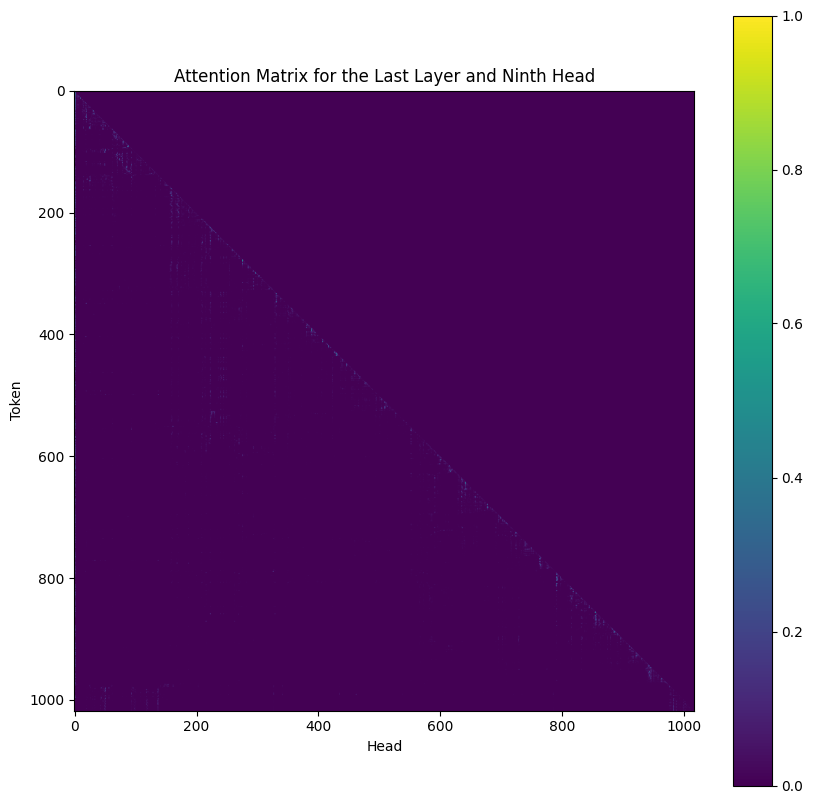

In [2]:
# Extract the attention matrix for the first layer and the 3rd token
attention_matrix = outputs.attentions[8][0, -1, :, :].detach().numpy()

# Plot the attention matrix
plt.figure(figsize=(10, 10))
plt.imshow(attention_matrix, cmap='viridis')
plt.colorbar()
plt.title('Attention Matrix for the Last Layer and Ninth Head')
plt.xlabel('Head')
plt.ylabel('Token')
plt.show()


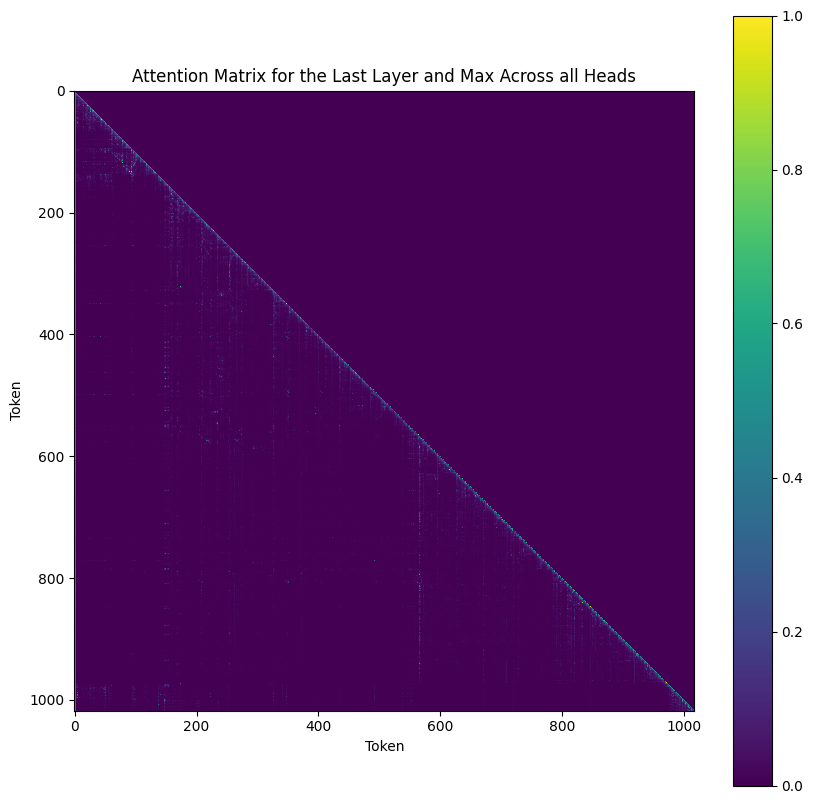

In [3]:
# Extract the attention matrix for the first layer and the 3rd token
attention_matrix = torch.max(torch.stack(outputs.attentions), dim=0).values.detach().numpy()
import numpy as np
attention_matrix = attention_matrix[0, 0, :, :]
# attention_matrix = np.max(attention_matrix, axis=1)

# Plot the attention matrix
plt.figure(figsize=(10, 10))
# plt.imshow(attention_matrix[0, :, :], cmap='viridis')
plt.imshow(attention_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Attention Matrix for the Last Layer and Max Across all Heads')
plt.xlabel('Token')
plt.ylabel('Token')
plt.show()

In [6]:
print(chunked_input[-100:])

d unless otherwise dictated by the story and can either help or impede a character ,<|end_chunk_21|>


In [4]:
print(len(input_ids[0]))

1018


In [32]:
# Get the last 5 input_ids
last_5_input_ids = input_ids[0][1013]

# Decode the last 5 input_ids
last_5_tokens = tokenizer.decode(last_5_input_ids)

# Print the last 5 tokens
print("Last 5 tokens: ", last_5_tokens)

Last 5 tokens:  Fourth


In [15]:
attention_matrix = torch.max(torch.stack(outputs.attentions), dim=0).values.detach().numpy()
import numpy as np
# attention_matrix = attention_matrix[0, 0, 1317, :]
attention_matrix = np.max(attention_matrix, axis=1)

print(attention_matrix.shape)

(1, 1319, 1319)


In [33]:
attention_matrix = torch.max(torch.stack(outputs.attentions), dim=0).values.detach().numpy()
import numpy as np
# attention_matrix = attention_matrix[0, 0, 1317, :]
attention_matrix = attention_matrix[:, -10:, :, :]
attention_matrix = np.max(attention_matrix, axis=1)

print(attention_matrix.shape)

attention_matrix = attention_matrix[0, 1013:1016, :]

# Sum along the first dimension
attention_matrix_sum = np.sum(attention_matrix, axis=0)


(1, 1018, 1018)
(3, 1018)


(1, 1018, 1018)
Mean: 0.03942123055458069
Median: 0.006426824722439051
Min: 0.0
Max: 1.7815778255462646
Std: 0.14037305116653442
Best position for a 300 token window: 304
Index: 156, Value: 0.11679428815841675
Index: 161, Value: 0.2244981825351715
Index: 162, Value: 0.1326913833618164
Index: 181, Value: 0.1281416267156601
Index: 214, Value: 0.12125301361083984
Index: 253, Value: 0.1068742573261261
Index: 327, Value: 0.11648009717464447
Index: 348, Value: 0.13916777074337006
Index: 435, Value: 0.14265401661396027
Index: 462, Value: 0.20240135490894318
Index: 486, Value: 0.10834646224975586
Index: 538, Value: 0.10860694944858551
Index: 549, Value: 0.24931985139846802
Index: 553, Value: 0.13031944632530212
Index: 555, Value: 0.20367424190044403
Index: 603, Value: 0.19094686210155487
Index: 720, Value: 0.2094176709651947
Index: 770, Value: 0.176902636885643
Index: 785, Value: 0.5588964819908142
Index: 846, Value: 0.30015358328819275


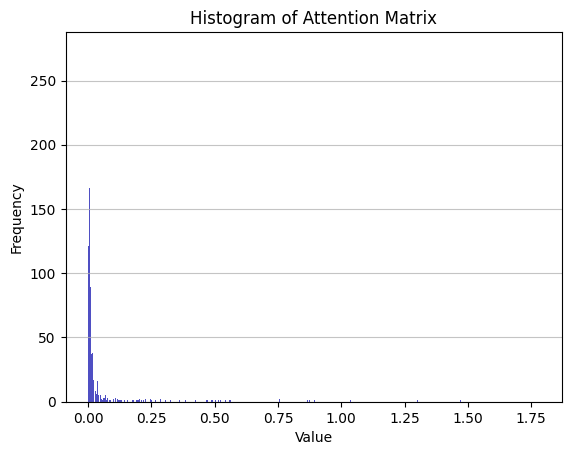

In [35]:
attention_matrix = torch.max(torch.stack(outputs.attentions), dim=0).values.detach().numpy()
import numpy as np
# attention_matrix = attention_matrix[0, 0, 1317, :]
attention_matrix = attention_matrix[:, -10:, :, :]
attention_matrix = np.max(attention_matrix, axis=1)

print(attention_matrix.shape)

attention_matrix = attention_matrix[0, 1013:1016, :]
attention_matrix = np.sum(attention_matrix, axis=0)

# Calculate and print the mean, median, min, max and std of the attention matrix
mean_value = np.mean(attention_matrix)
median_value = np.median(attention_matrix)
min_value = np.min(attention_matrix)
max_value = np.max(attention_matrix)
std_value = np.std(attention_matrix)

print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Min: {min_value}")
print(f"Max: {max_value}")
print(f"Std: {std_value}")


start_corpus_index = 155
end_of_corpus_index = 971

# Define the window size
window_size = 300

# Initialize the best sum and best position
best_sum = -np.inf
best_position = -1

# Iterate over the possible start positions of the window
for start_position in range(start_corpus_index, end_of_corpus_index - window_size + 1):
    # Calculate the sum of the window
    window_sum = np.sum(attention_matrix[start_position:start_position + window_size])
    
    # If this sum is better than the current best, update the best sum and best position
    if window_sum > best_sum:
        best_sum = window_sum
        best_position = start_position

# Print the best position
print(f"Best position for a 300 token window: {best_position}")


# Get the indices of the top 20 values in the attention matrix within the corpus range
corpus_attention_matrix = attention_matrix[start_corpus_index:end_of_corpus_index]
top_20_indices = np.argpartition(corpus_attention_matrix, -20)[-20:]
top_20_values = corpus_attention_matrix[top_20_indices]

# Adjust the indices to reflect their position in the original attention matrix
top_20_indices += start_corpus_index

# Sort the indices
sorted_indices = np.argsort(top_20_indices)


# # Get the indices of the top 20 values in the attention matrix
# top_20_indices = np.argpartition(attention_matrix, -20)[-20:]
# top_20_values = attention_matrix[top_20_indices]

# # Sort the indices
# sorted_indices = np.argsort(top_20_indices)


# Print the indices of the top 20 along with their values in order of index
for index in sorted_indices:
    print(f"Index: {top_20_indices[index]}, Value: {top_20_values[index]}")


plt.hist(attention_matrix, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Attention Matrix')
plt.show()


In [9]:
def string_about_index(ids_index):
    return tokenizer.decode(input_ids[0][ids_index-10:ids_index+10])

In [22]:
string_about_index(980)

" otherwise dic<|end_of_corpus|>\n\nRespond with the chunk and it's corresponding text from the"

In [26]:
tokenizer.decode(input_ids[0][971])

' dic'

In [28]:


for index in sorted_indices:
    # top_input_ids.append(input_ids[0][top_20_indices[index]])
    print(f"Index: {top_20_indices[index]}, Token: {tokenizer.decode([input_ids[0][top_20_indices[index]]])}")
    print(f"String: {string_about_index(top_20_indices[index])}")

# top_tokens = tokenizer.decode(top_input_ids)

# for index, top_token in zip(sorted_indices, top_tokens):
#     # top_input_ids.append(input_ids[0][top_20_indices[index]])
#     print(f"Index: {top_20_indices[index]}, Token: {top_token}")


Index: 161, Token:  =
String: _of_corpus|> = Valkyria Chronicles III = 
 Senjō no Valkyria 
Index: 214, Token:  is
String:  to as Valkyria Chronicles III outside Japan, is a tactical role @-@ playing video game
Index: 253, Token: y
String:  Japan, it is the third game in the Valkyria series. Employing the same fusion of
Index: 327, Token:  

String:  the Imperial unit " <unk> Raven ". 
 The game began development in 2010,
Index: 341, Token:  portion
String:  development in 2010, carrying over a large portion of the work done on Valkyria Chronicles
Index: 348, Token: y
String:  over a large portion of the work done on Valkyria Chronicles II. While it retained the standard
Index: 435, Token:  

String: s opening theme was sung by May 'n. 
 It met with positive sales in Japan, and
Index: 462, Token:  along
String:  critics. After release, it received downloadable content, along with an expanded edition in November of that year
Index: 492, Token: y
String:  video animation series. Due to l